# 作業

實作各種不一樣的方式來調整飽和 / 對比 / 明亮

1. 改變 color space 來調整飽和度
2. 實作直方圖均衡
3. alpha/ beta 調整對比 / 明亮

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
img_path = 'data/lena.png'

# 以彩色圖片的方式載入
img = cv2.imread(img_path, cv2.IMREAD_COLOR)

# # test image
# step = 1
# img = np.array([[[i,j,abs(255-i-j)] for i in range(0,256,step)] for j in range(0,256,step)],dtype="uint8")

## 改變飽和度

- 轉換成 HSV color space, 改變 s channel 的值

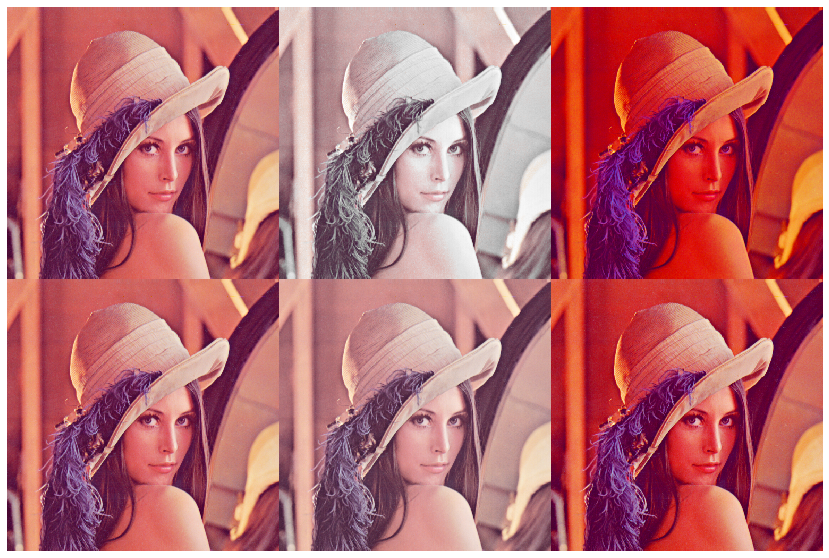

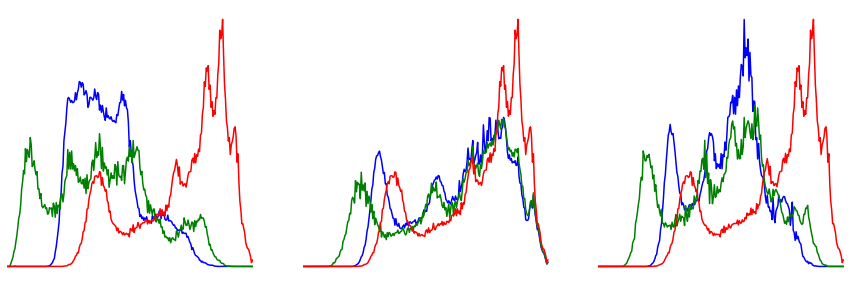

In [2]:
# 為了要改變飽和度，我們先把 color space 轉成 HSV 格式
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
change_percentage = 0.4

# 針對飽和度的值做改變，超過界線 0~1 的都會 bound
# 在 HSV color space 減少飽和度
img_hsv_down1 = img_hsv.astype("float32")
img_hsv_down1[..., 1] = img_hsv_down1[..., 1]/255 - change_percentage
img_hsv_down1[..., 1][img_hsv_down1[..., 1] < 0] = 0
img_hsv_down1[..., 1] = img_hsv_down1[..., 1]*255
img_hsv_down1 = img_hsv_down1.astype('uint8')

img_hsv_down2 = img_hsv.astype("float32")
img_hsv_down2[..., 1] = img_hsv_down2[..., 1] * (1 - change_percentage)
img_hsv_down2 = img_hsv_down2.astype('uint8')
# 在 HSV color space 增加飽和度
img_hsv_up1 = img_hsv.astype("float32")
img_hsv_up1[..., 1] = img_hsv_up1[..., 1]/255 + change_percentage
img_hsv_up1[..., 1][img_hsv_up1[..., 1] > 1] = 1
img_hsv_up1[..., 1] = img_hsv_up1[..., 1]*255
img_hsv_up1 = img_hsv_up1.astype('uint8')

img_hsv_up2 = img_hsv.astype("float32")
img_hsv_up2[..., 1] = img_hsv_up2[..., 1] * (1 + change_percentage)
img_hsv_up2[..., 1][img_hsv_up2[..., 1] > 255] = 255
img_hsv_up2 = img_hsv_up2.astype('uint8')

# 轉換 color space 回 BGR
img_hsv_down1 = cv2.cvtColor(img_hsv_down1, cv2.COLOR_HSV2BGR)
img_hsv_down2 = cv2.cvtColor(img_hsv_down2, cv2.COLOR_HSV2BGR)
img_hsv_up1 = cv2.cvtColor(img_hsv_up1, cv2.COLOR_HSV2BGR)
img_hsv_up2 = cv2.cvtColor(img_hsv_up2, cv2.COLOR_HSV2BGR)

# 組合圖片 + 顯示圖片
img_hsv_change1 = np.hstack((img, img_hsv_down1, img_hsv_up1))
img_hsv_change2 = np.hstack((img, img_hsv_down2, img_hsv_up2))
img_hsv_change3 = np.vstack((img_hsv_change1, img_hsv_change2))
plt.figure(figsize=(15,10))
plt.imshow(img_hsv_change3[...,::-1])
plt.axis('off')
plt.show()

plt.figure(figsize=(15,5))
for num, Img in enumerate([img, img_hsv_down1, img_hsv_down2]):
    plt.subplot(1,3,num+1)
    color = ('b','g','r')
    for i, col in enumerate(color):
      histr = cv2.calcHist([Img],[i],None,[256],[0, 256])
      plt.plot(histr, color = col)
      plt.xlim([0, 256])
      plt.axis('off')
plt.show()

## 直方圖均衡

1. case 1: 把彩圖拆開對每個 channel 個別做直方圖均衡再組合起來
2. case 2: 轉換 color space 到 HSV 之後對其中一個 channel 做直方圖均衡

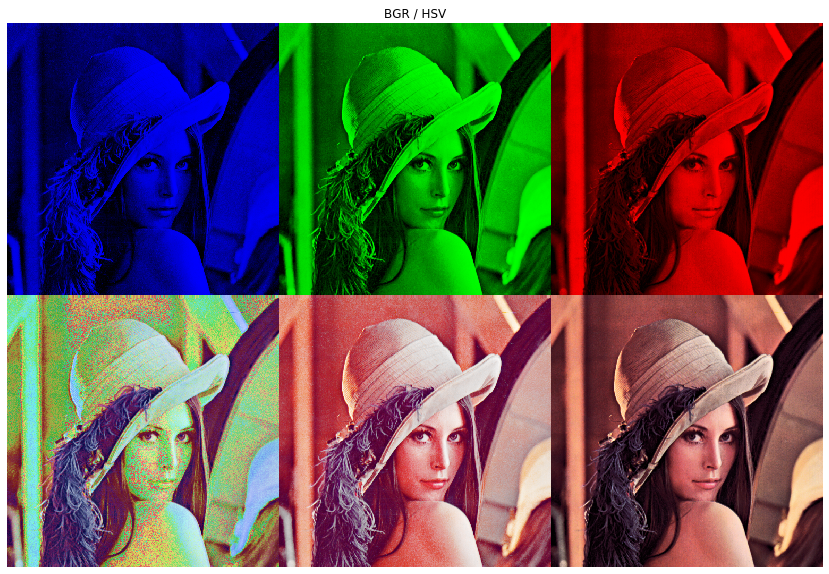

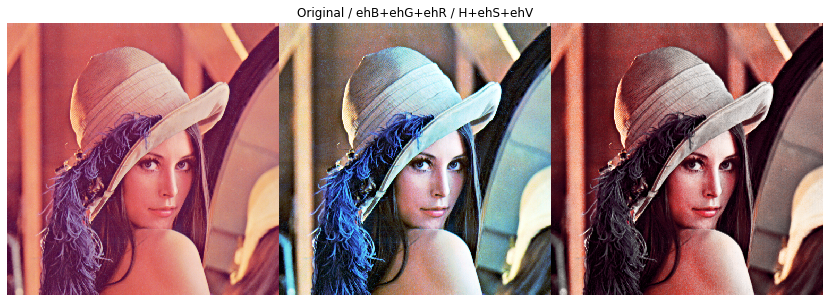

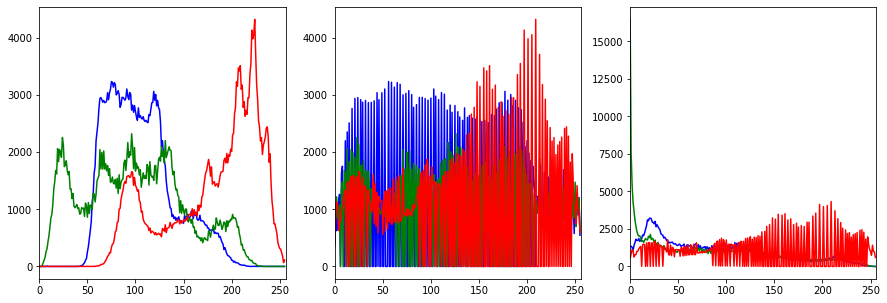

In [3]:
# case 1
# 每個 channel 個別做直方圖均衡
# img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
equalHist_by_channel = []
split_img = cv2.split(img)
for channel_img in split_img:
    channel_img = cv2.equalizeHist(channel_img)
    equalHist_by_channel.append(channel_img)
Z = np.zeros(img.shape[:2], dtype = "uint8")
# equalHist_by_channel = cv2.equalizeHist()
ehB, ehG, ehR = equalHist_by_channel


# 組合經過直方圖均衡的每個 channel
img_bgr_equal = cv2.merge(equalHist_by_channel)
img_bgr_equal_by_channel = np.hstack([
                            cv2.merge([ehB, Z, Z]),
                            cv2.merge([Z, ehG, Z]),
                            cv2.merge([Z, Z, ehR])
                            ])

# case 2 - 轉換 color space 後只對其中一個 channel 做直方圖均衡
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
equalHist_hsv_by_channel = []
split_img_hsv = cv2.split(img_hsv)
H, S, V = split_img_hsv
for channel_img in split_img_hsv:
    channel_img = cv2.equalizeHist(channel_img)
    equalHist_hsv_by_channel.append(channel_img)
ehH, ehS, ehV = equalHist_hsv_by_channel

img_hsv_equal = cv2.merge([H, ehS, ehV])
img_hsv_equal_by_channel = np.hstack([
                            cv2.merge([ehH, S, V]),
                            cv2.merge([H, ehS, V]),
                            cv2.merge([H, S, ehV])
                            ])
img_hsv_equal_by_channel = cv2.cvtColor(img_hsv_equal_by_channel, cv2.COLOR_HSV2BGR)
img_hsv_equal = cv2.cvtColor(img_hsv_equal, cv2.COLOR_HSV2BGR)

img_stack = np.vstack([img_bgr_equal_by_channel, img_hsv_equal_by_channel])
# 組合圖片 + 顯示圖片

img_merge_stack = np.hstack([img, img_bgr_equal, img_hsv_equal])

plt.figure(figsize=(15,10))
plt.imshow(img_stack[...,::-1])
plt.title("BGR / HSV")
plt.axis('off')
plt.show()
plt.figure(figsize=(15,5))
plt.imshow(img_merge_stack[...,::-1])
plt.title("Original / ehB+ehG+ehR / H+ehS+ehV")
plt.axis('off')
plt.show()

plt.figure(figsize=(15,5))
for num, Img in enumerate([img, img_bgr_equal, img_hsv_equal]):
    plt.subplot(1,3,num+1)
    color = ('b','g','r')
    for i, col in enumerate(color):
      histr = cv2.calcHist([Img],[i],None,[256],[0, 256])
      plt.plot(histr, color = col)
      plt.xlim([0, 256])
plt.show()

## 調整對比 / 明亮

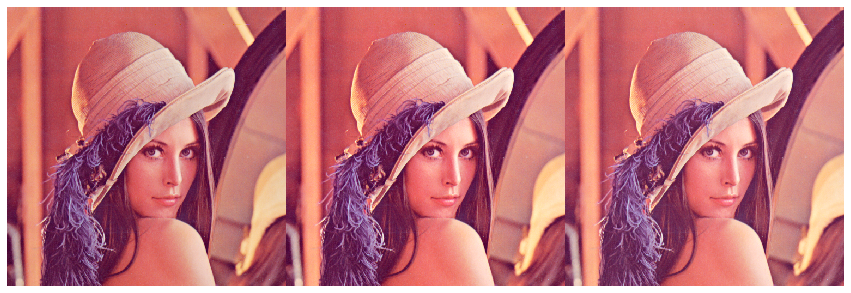

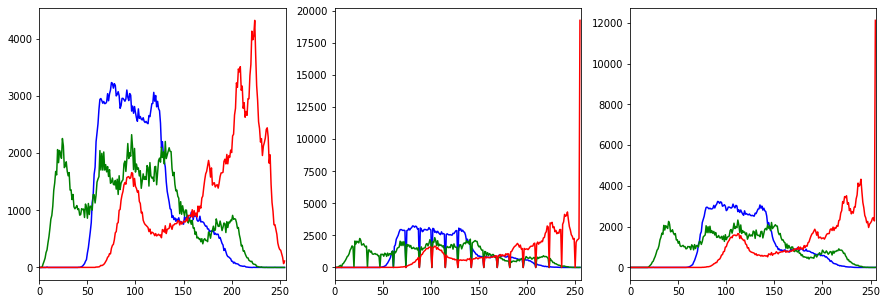

In [4]:
# alpha: 控制對比度 (1.0~3.0)
# beta: 控制明亮度 (0~255)
add_contrast = cv2.convertScaleAbs(img, alpha=1.08, beta=0)
add_lighness = cv2.convertScaleAbs(img, alpha=1.0, beta=16)

# 組合圖片 + 顯示圖片
img_contrast_light = np.hstack((img, add_contrast, add_lighness))

plt.figure(figsize=(15,15))
plt.imshow(img_contrast_light[...,::-1])
plt.axis('off')
plt.show()


plt.figure(figsize=(15,5))
for num, Img in enumerate([img, add_contrast, add_lighness]):
    plt.subplot(1,3,num+1)
    color = ('b','g','r')
    for i, col in enumerate(color):
      histr = cv2.calcHist([Img],[i],None,[256],[0, 256])
      plt.plot(histr, color = col)
      plt.xlim([0, 256])
plt.show()